# RIGOROUS GRANULAR SWEEP: THE LOW-PASS INDUCTION FILTER
## Reference: Appendix-F
## Kingsuk Maitra, Qualcomm AI Cloud Division

**DESIGNED FOR:** NVIDIA A100 (40GB)

**OBJECTIVE:**
Generate a high-resolution Phase Diagram of Momentum-Augmented Attention to empirically validate the "Low-Pass Induction" theory.

**THEORY TO VALIDATE:**
1. Low Frequencies (Theta → 0) act as clean Induction Channels.
2. High Frequencies (Theta → π) are noise-corrupted by rotation.
3. Success requires Gamma to be in the "Passband" of the filter.

In [ ]:
# ============================================================================
# CELL 1: IMPORTS AND CONFIGURATION
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
import pandas as pd
import math
import time
import os
import sys
import warnings
import gc
from datetime import datetime

# Suppress warnings
warnings.filterwarnings('ignore')

# Publication-quality plots
sns.set_theme(context='paper', style='whitegrid', font_scale=1.4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# Robust Device Detection
IS_TPU = False
try:
    import torch_xla.core.xla_model as xm
    DEVICE = xm.xla_device()
    print(f"🚀 Execution initialized on TPU (XLA): {DEVICE}")
    IS_TPU = True
except ImportError:
    if torch.cuda.is_available():
        DEVICE = torch.device('cuda')
        GPU_NAME = torch.cuda.get_device_name(0)
        GPU_MEM = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"🚀 Execution initialized on GPU: {GPU_NAME}")
        print(f"   Memory: {GPU_MEM:.1f} GB")
    else:
        DEVICE = torch.device('cpu')
        print("⚠️  Execution initialized on CPU (Slow!)")

print(f"📅 Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 PyTorch version: {torch.__version__}")

def set_seed(seed):
    """Set all random seeds for reproducibility."""
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

🚀 Execution initialized on GPU: NVIDIA A100-SXM4-40GB
   Memory: 42.5 GB
📅 Started: 2026-01-17 06:10:12
🔧 PyTorch version: 2.9.0+cu126


In [ ]:
# ============================================================================
# CELL 2: BANDPASS ROPE (Spectral Window)
# ============================================================================

class BandpassRoPE(nn.Module):
    """
    RoPE with a controllable frequency band [theta_min, theta_max].
    This isolates the model's spectral attention to a specific regime.
    """
    def __init__(self, dim: int, center_theta: float, bandwidth: float = 0.2, max_len: int = 5000):
        super().__init__()
        self.dim = dim
        self.max_len = max_len

        t_min = center_theta * (1.0 - bandwidth)
        t_max = center_theta * (1.0 + bandwidth)

        inv_freq = torch.linspace(t_min, t_max, steps=dim // 2)
        self.register_buffer('inv_freq', inv_freq)

        self.cos_cached = None
        self.sin_cached = None
        self.cached_len = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.shape[1]
        device = x.device

        if self.cos_cached is None or seq_len > self.cached_len or self.cos_cached.device != device:
            self.cached_len = max(seq_len, self.max_len)
            t = torch.arange(self.cached_len, device=device).float()
            freqs = torch.outer(t, self.inv_freq.to(device))

            emb = freqs
            self.cos_cached = emb.cos()[None, :, None, :]
            self.sin_cached = emb.sin()[None, :, None, :]

        cos = self.cos_cached[:, :seq_len, :, :]
        sin = self.sin_cached[:, :seq_len, :, :]

        x1 = x[..., :self.dim // 2]
        x2 = x[..., self.dim // 2:]

        return torch.cat((x1 * cos - x2 * sin, x1 * sin + x2 * cos), dim=-1)

print("✅ BandpassRoPE defined")

✅ BandpassRoPE defined


In [ ]:
# ============================================================================
# CELL 3: MOMENTUM ATTENTION MODULE
# ============================================================================

class MomentumAttention(nn.Module):
    """
    Rigorous Momentum Attention:
    1. Project Q, K
    2. Apply RoPE (Once)
    3. Compute Momentum (Difference of Rotated Vectors)
    4. Apply Symplectic Shear (Q + gamma*P)
    """
    def __init__(self, d_model: int, n_heads: int, gamma: float, center_theta: float):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.d_head = d_model // n_heads
        self.n_heads = n_heads
        self.gamma = gamma
        self.scale = 1.0 / math.sqrt(self.d_head)

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)

        self.rope = BandpassRoPE(self.d_head, center_theta)

    def forward(self, x: torch.Tensor, mask=None):
        B, L, D = x.shape

        q = self.W_q(x).reshape(B, L, self.n_heads, self.d_head)
        k = self.W_k(x).reshape(B, L, self.n_heads, self.d_head)
        v = self.W_v(x).reshape(B, L, self.n_heads, self.d_head)

        q_rot = self.rope(q)
        k_rot = self.rope(k)

        p_q = torch.zeros_like(q_rot)
        p_k = torch.zeros_like(k_rot)

        if L > 1:
            p_q[:, 1:] = q_rot[:, 1:] - q_rot[:, :-1]
            p_k[:, 1:] = k_rot[:, 1:] - k_rot[:, :-1]

        q_hat = q_rot + self.gamma * p_q
        k_hat = k_rot + self.gamma * p_k

        q_hat = q_hat.transpose(1, 2)
        k_hat = k_hat.transpose(1, 2)
        v_t = v.transpose(1, 2)

        scores = torch.matmul(q_hat, k_hat.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v_t)

        return self.W_o(out.transpose(1, 2).reshape(B, L, D))

print("✅ MomentumAttention defined")

✅ MomentumAttention defined


In [ ]:
# ============================================================================
# CELL 4: DATASET AND TRAINING UTILITIES
# ============================================================================

class ARDataset(Dataset):
    """
    Associative Recall Task:
    Input: [k1, v1, k2, v2, ..., kn, vn, q_key]
    Target: q_val
    """
    def __init__(self, n, vocab, length):
        self.data = []
        for _ in range(n):
            keys = torch.randperm(vocab // 2)[:length]
            vals = torch.randint(vocab // 2, vocab, (length,))
            seq = torch.zeros(length * 2 + 1, dtype=torch.long)
            seq[0:2 * length:2] = keys
            seq[1:2 * length:2] = vals
            idx = torch.randint(0, length, (1,)).item()
            seq[-1] = keys[idx]
            self.data.append((seq, vals[idx]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return self.data[i]


def train_one_model(gamma, theta, seed):
    """Train a single model configuration and return test accuracy."""
    set_seed(seed)

    model = nn.Sequential(
        nn.Embedding(128, 64),
        MomentumAttention(64, 4, gamma, theta),
        nn.LayerNorm(64),
        nn.Linear(64, 128)
    ).to(DEVICE)

    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

    ds = ARDataset(2000, 128, 8)
    dl = DataLoader(ds, batch_size=128, shuffle=True, drop_last=True)

    model.train()
    for ep in range(8):
        for x, y in dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            logits = model(x)[:, -1]
            loss = F.cross_entropy(logits, y)

            opt.zero_grad()
            loss.backward()
            if IS_TPU:
                xm.optimizer_step(opt)
            else:
                opt.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            pred = model(x)[:, -1].argmax(-1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    del model, opt, ds, dl
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return correct / total

print("✅ ARDataset and train_one_model defined")

✅ ARDataset and train_one_model defined


In [ ]:
# ============================================================================
# CELL 5: MAIN EXPERIMENT - THE GRANULAR SWEEP
# ============================================================================

def run_granular_sweep():
    print("=" * 66)
    print("STARTING RIGOROUS GRANULAR SWEEP")
    print("=" * 66)

    gammas = np.concatenate([
        np.linspace(0.0, 1.0, 11),
        np.linspace(1.2, 3.0, 5)
    ])

    thetas = np.logspace(np.log10(0.03), np.log10(3.0), 15)

    SEEDS = [42, 101, 999]

    results = []
    total_runs = len(gammas) * len(thetas) * len(SEEDS)
    counter = 0
    start_time = time.time()

    print(f"Grid Size: {len(thetas)} Freqs x {len(gammas)} Gammas")
    print(f"Seeds per Point: {len(SEEDS)}")
    print(f"Total Models to Train: {total_runs}")
    print("-" * 66)
    print(f"{'Theta':<10} | {'Gamma':<10} | {'Mean Acc':<10} | {'Std Dev':<10} | Progress")
    print("-" * 66)

    for t in thetas:
        for g in gammas:
            accs = []
            for s in SEEDS:
                acc = train_one_model(g, t, s)
                accs.append(acc)
                counter += 1

            mean_acc = np.mean(accs)
            std_acc = np.std(accs)

            progress = f"{counter}/{total_runs} ({100*counter/total_runs:.1f}%)"
            print(f"{t:<10.4f} | {g:<10.2f} | {mean_acc:<10.3f} | {std_acc:<10.3f} | {progress}")

            results.append({
                'Theta': t,
                'Gamma': g,
                'Mean_Acc': mean_acc,
                'Std_Acc': std_acc
            })

    duration = time.time() - start_time
    print("=" * 66)
    print(f"SWEEP COMPLETE. Time: {duration/60:.1f} minutes ({duration/3600:.2f} hours)")
    print("=" * 66)

    return pd.DataFrame(results)

print("✅ run_granular_sweep defined")

✅ run_granular_sweep defined


In [ ]:
# ============================================================================
# CELL 6: PLOTTING FUNCTIONS (FIXED - removed invalid fontweight parameter)
# ============================================================================

def generate_paper_plots(df):
    """
    Generate publication-quality plots with properly superimposed contours.
    """
    piv = df.pivot(index='Theta', columns='Gamma', values='Mean_Acc')
    piv = piv.sort_index(ascending=True)

    gamma_vals = np.array(piv.columns.astype(float))
    theta_vals = np.array(piv.index.astype(float))
    Z = piv.values

    XX, YY = np.meshgrid(gamma_vals, theta_vals)

    # =========================================================================
    # FIGURE 1: Heatmap with Superimposed Iso-Accuracy Contours
    # =========================================================================
    fig, ax = plt.subplots(figsize=(14, 10))

    pcm = ax.pcolormesh(XX, YY, Z, cmap='viridis', vmin=0, vmax=1.0, shading='nearest')
    cbar = plt.colorbar(pcm, ax=ax, label='Recall Accuracy')

    contour_levels = [0.3, 0.5, 0.7, 0.9]
    CS = ax.contour(XX, YY, Z, levels=contour_levels,
                    colors=['white', 'yellow', 'orange', 'red'],
                    linewidths=2.5, linestyles='solid')
    # Fixed: removed fontweight parameter which is not supported by clabel
    ax.clabel(CS, inline=True, fontsize=12, fmt='%.1f')

    ax.set_yscale('log')
    ax.set_xlabel('Momentum Coupling (γ)', fontsize=14)
    ax.set_ylabel('Center Frequency (θ) [Log Scale]', fontsize=14)
    ax.set_title('The Low-Pass Induction Filter\n(Accuracy vs. Spectral Band & Momentum)',
                 fontsize=16, fontweight='bold')

    ax.text(0.7, 0.15, 'High Fidelity\nInduction Zone',
            transform=ax.transAxes, fontsize=12, fontweight='bold',
            color='white', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='green', alpha=0.7))

    ax.text(0.3, 0.85, 'Noise-Corrupted\nRegime',
            transform=ax.transAxes, fontsize=11, fontweight='bold',
            color='white', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='darkred', alpha=0.7))

    plt.tight_layout()
    plt.savefig('low_pass_induction_heatmap_with_contours.png', dpi=300, bbox_inches='tight')
    plt.savefig('low_pass_induction_heatmap_with_contours.pdf', bbox_inches='tight')
    plt.show()
    print("✅ Saved: low_pass_induction_heatmap_with_contours.png/pdf")

    # =========================================================================
    # FIGURE 2: Clean Heatmap (without contours)
    # =========================================================================
    fig, ax = plt.subplots(figsize=(14, 10))

    pcm = ax.pcolormesh(XX, YY, Z, cmap='viridis', vmin=0, vmax=1.0, shading='nearest')
    cbar = plt.colorbar(pcm, ax=ax, label='Recall Accuracy')

    ax.set_yscale('log')
    ax.set_xlabel('Momentum Coupling (γ)', fontsize=14)
    ax.set_ylabel('Center Frequency (θ) [Log Scale]', fontsize=14)
    ax.set_title('Phase Diagram: Momentum-Augmented Attention',
                 fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('low_pass_induction_heatmap_clean.png', dpi=300, bbox_inches='tight')
    plt.savefig('low_pass_induction_heatmap_clean.pdf', bbox_inches='tight')
    plt.show()
    print("✅ Saved: low_pass_induction_heatmap_clean.png/pdf")

    # =========================================================================
    # FIGURE 3: Contours with Filled Background (Phase Boundaries)
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 8))

    cf = ax.contourf(XX, YY, Z, levels=20, cmap='viridis', alpha=0.9)
    plt.colorbar(cf, ax=ax, label='Recall Accuracy')

    CS = ax.contour(XX, YY, Z, levels=[0.3, 0.5, 0.7, 0.9],
                    colors=['white', 'yellow', 'orange', 'red'],
                    linewidths=2.5)
    ax.clabel(CS, inline=True, fontsize=11, fmt='%.2f')

    ax.set_yscale('log')
    ax.grid(True, which='both', ls='--', alpha=0.3, color='white')
    ax.set_xlabel('Momentum Coupling (γ)', fontsize=14)
    ax.set_ylabel('Frequency (θ)', fontsize=14)
    ax.set_title('Phase Boundaries: Iso-Accuracy Contours',
                 fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.savefig('low_pass_phase_boundaries.png', dpi=300, bbox_inches='tight')
    plt.savefig('low_pass_phase_boundaries.pdf', bbox_inches='tight')
    plt.show()
    print("✅ Saved: low_pass_phase_boundaries.png/pdf")

    # =========================================================================
    # FIGURE 4: Slice Plots at Key Theta Values
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 6))

    n_thetas = len(theta_vals)
    slice_indices = [0, n_thetas//4, n_thetas//2, n_thetas-1]
    colors = ['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728']

    for idx, color in zip(slice_indices, colors):
        theta = theta_vals[idx]
        acc_slice = Z[idx, :]
        ax.plot(gamma_vals, acc_slice, 'o-', color=color,
                label=f'θ = {theta:.3f}', markersize=6, linewidth=2)

    ax.set_xlabel('Momentum Coupling (γ)', fontsize=14)
    ax.set_ylabel('Recall Accuracy', fontsize=14)
    ax.set_title('Accuracy vs Gamma at Different Frequencies',
                 fontsize=16, fontweight='bold')
    ax.legend(title='Frequency', fontsize=11, title_fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    ax.set_xlim([gamma_vals.min() - 0.1, gamma_vals.max() + 0.1])

    ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(y=0.9, color='gray', linestyle=':', alpha=0.5)

    plt.tight_layout()
    plt.savefig('low_pass_accuracy_slices.png', dpi=300, bbox_inches='tight')
    plt.savefig('low_pass_accuracy_slices.pdf', bbox_inches='tight')
    plt.show()
    print("✅ Saved: low_pass_accuracy_slices.png/pdf")

    # =========================================================================
    # FIGURE 5: Gamma Slices (Accuracy vs Theta at fixed Gamma)
    # =========================================================================
    fig, ax = plt.subplots(figsize=(12, 6))

    gamma_slice_vals = [0.0, 0.3, 0.7, 1.0, 1.5]
    colors = plt.cm.plasma(np.linspace(0.1, 0.9, len(gamma_slice_vals)))

    for gval, color in zip(gamma_slice_vals, colors):
        g_idx = np.argmin(np.abs(gamma_vals - gval))
        actual_gamma = gamma_vals[g_idx]
        acc_slice = Z[:, g_idx]
        ax.semilogx(theta_vals, acc_slice, 'o-', color=color,
                    label=f'γ = {actual_gamma:.1f}', markersize=6, linewidth=2)

    ax.set_xlabel('Center Frequency (θ)', fontsize=14)
    ax.set_ylabel('Recall Accuracy', fontsize=14)
    ax.set_title('Accuracy vs Frequency at Different Momentum Couplings',
                 fontsize=16, fontweight='bold')
    ax.legend(title='Momentum', fontsize=11, title_fontsize=12)
    ax.grid(True, alpha=0.3, which='both')
    ax.set_ylim([0, 1.05])

    plt.tight_layout()
    plt.savefig('low_pass_frequency_slices.png', dpi=300, bbox_inches='tight')
    plt.savefig('low_pass_frequency_slices.pdf', bbox_inches='tight')
    plt.show()
    print("✅ Saved: low_pass_frequency_slices.png/pdf")

print("✅ generate_paper_plots defined")

✅ generate_paper_plots defined


In [ ]:
# ============================================================================
# CELL 7: RUN THE EXPERIMENT
# ============================================================================

df_results = run_granular_sweep()

df_results.to_csv('granular_sweep_results.csv', index=False)
print("\n✅ Saved raw results: granular_sweep_results.csv")

print("\n" + "=" * 66)
print("SUMMARY STATISTICS")
print("=" * 66)
print(f"Total configurations: {len(df_results)}")
print(f"Max accuracy: {df_results['Mean_Acc'].max():.3f}")
print(f"Min accuracy: {df_results['Mean_Acc'].min():.3f}")
print(f"Mean accuracy: {df_results['Mean_Acc'].mean():.3f}")

best_idx = df_results['Mean_Acc'].idxmax()
best = df_results.loc[best_idx]
print(f"\nOptimal Configuration:")
print(f"  Theta: {best['Theta']:.4f}")
print(f"  Gamma: {best['Gamma']:.2f}")
print(f"  Accuracy: {best['Mean_Acc']:.3f} ± {best['Std_Acc']:.3f}")

STARTING RIGOROUS GRANULAR SWEEP
Grid Size: 15 Freqs x 16 Gammas
Seeds per Point: 3
Total Models to Train: 720
------------------------------------------------------------------
Theta      | Gamma      | Mean Acc   | Std Dev    | Progress
------------------------------------------------------------------
0.0300     | 0.00       | 0.356      | 0.002      | 3/720 (0.4%)
0.0300     | 0.10       | 0.393      | 0.005      | 6/720 (0.8%)
0.0300     | 0.20       | 0.428      | 0.004      | 9/720 (1.2%)
0.0300     | 0.30       | 0.472      | 0.008      | 12/720 (1.7%)
0.0300     | 0.40       | 0.511      | 0.015      | 15/720 (2.1%)
0.0300     | 0.50       | 0.546      | 0.021      | 18/720 (2.5%)
0.0300     | 0.60       | 0.578      | 0.031      | 21/720 (2.9%)
0.0300     | 0.70       | 0.593      | 0.032      | 24/720 (3.3%)
0.0300     | 0.80       | 0.599      | 0.037      | 27/720 (3.8%)
0.0300     | 0.90       | 0.593      | 0.041      | 30/720 (4.2%)
0.0300     | 1.00       | 0.581      

✅ Saved: low_pass_induction_heatmap_with_contours.png/pdf


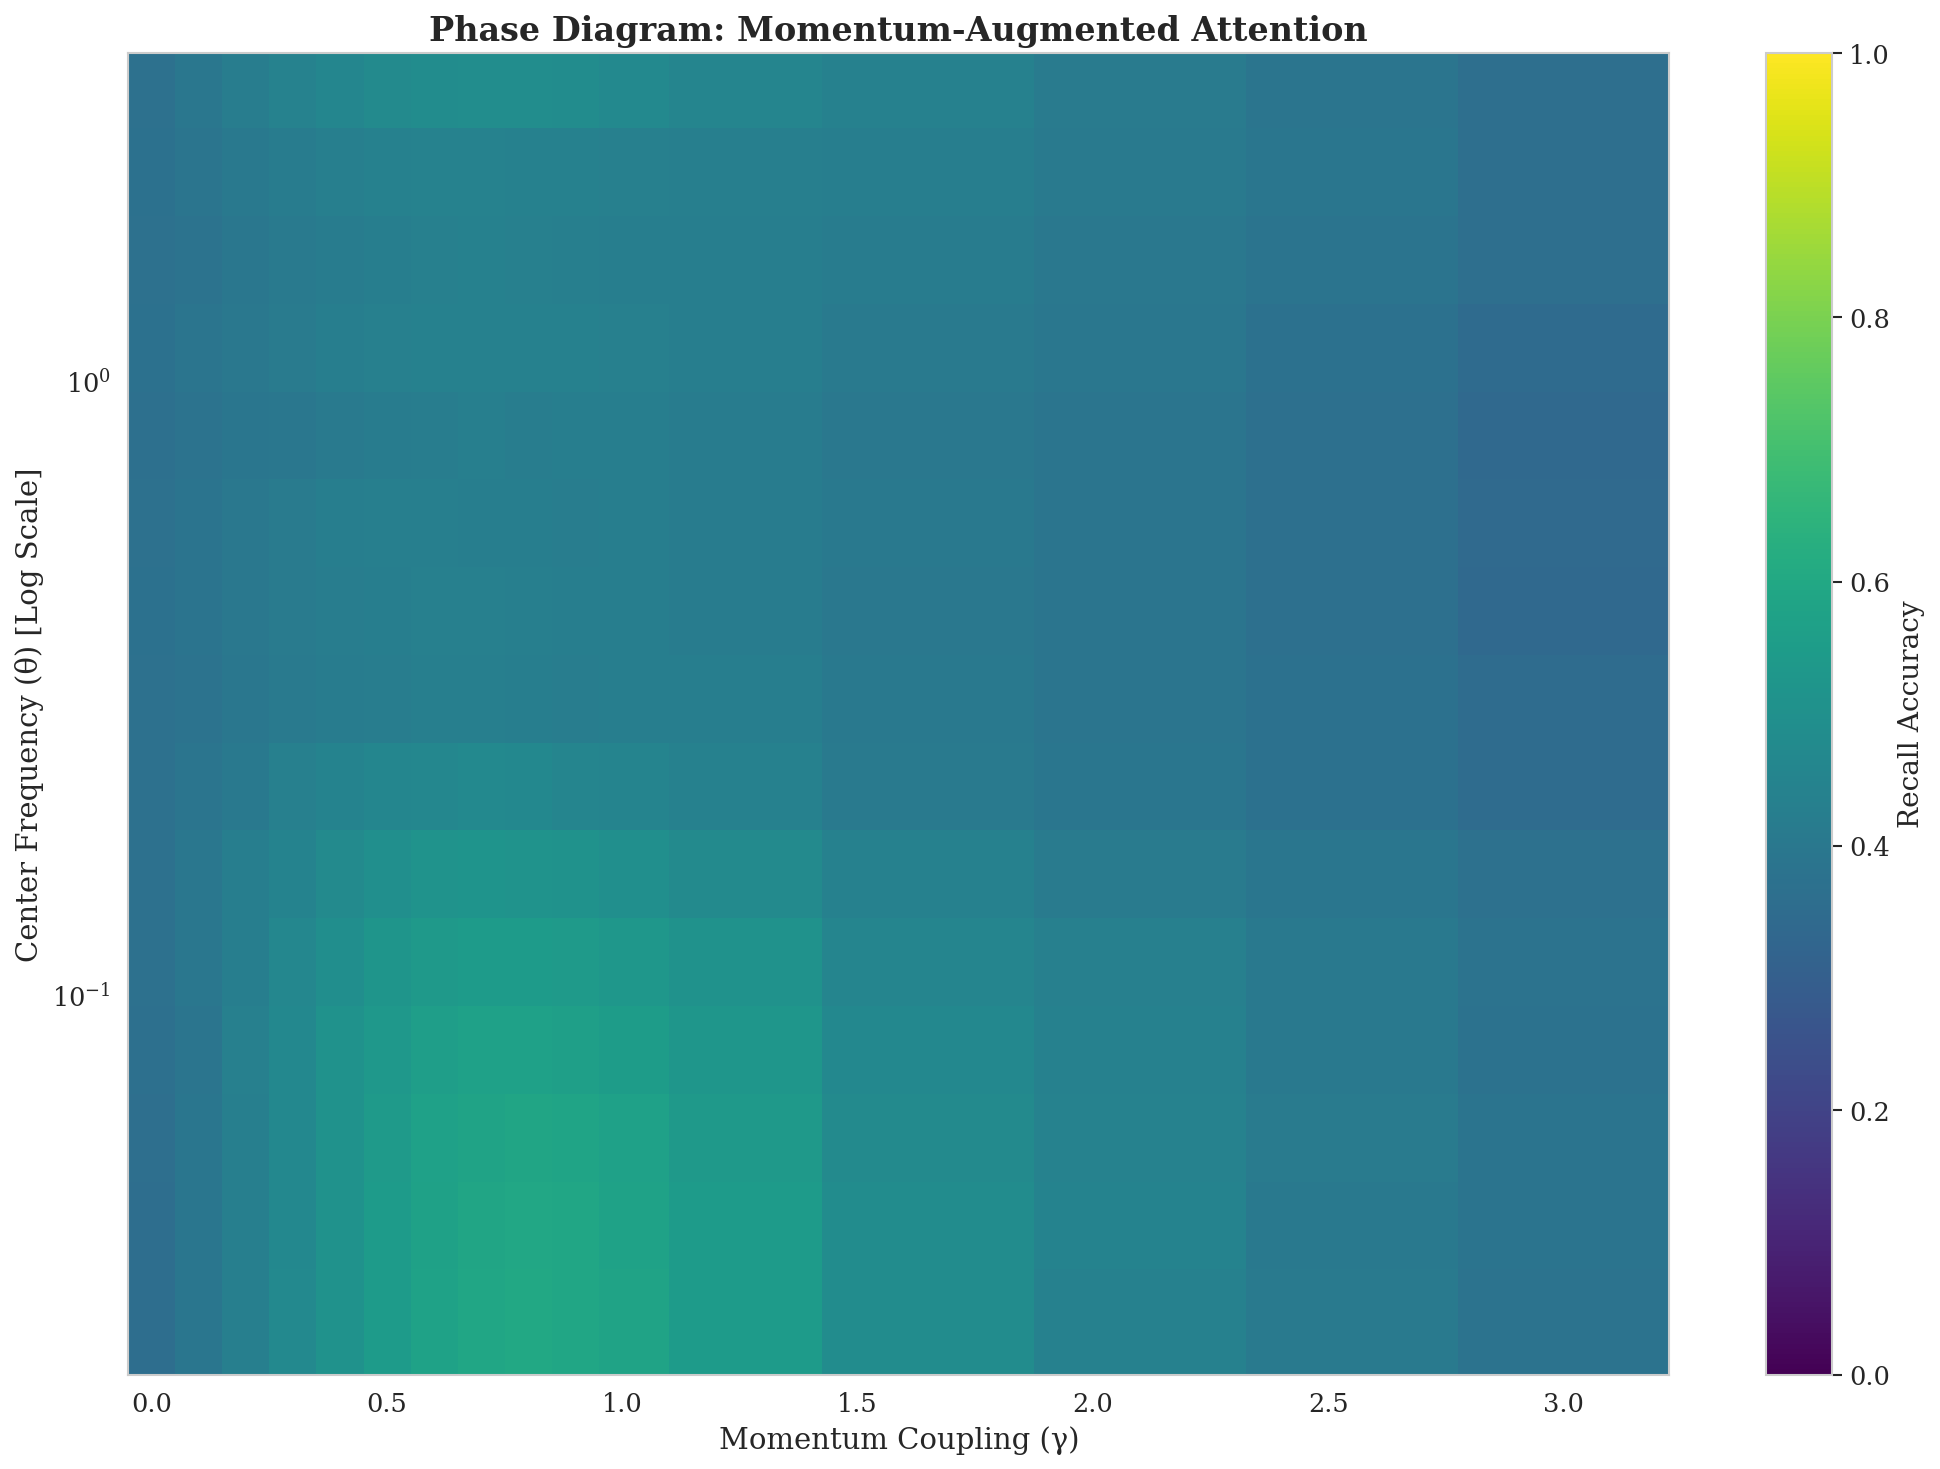

✅ Saved: low_pass_induction_heatmap_clean.png/pdf


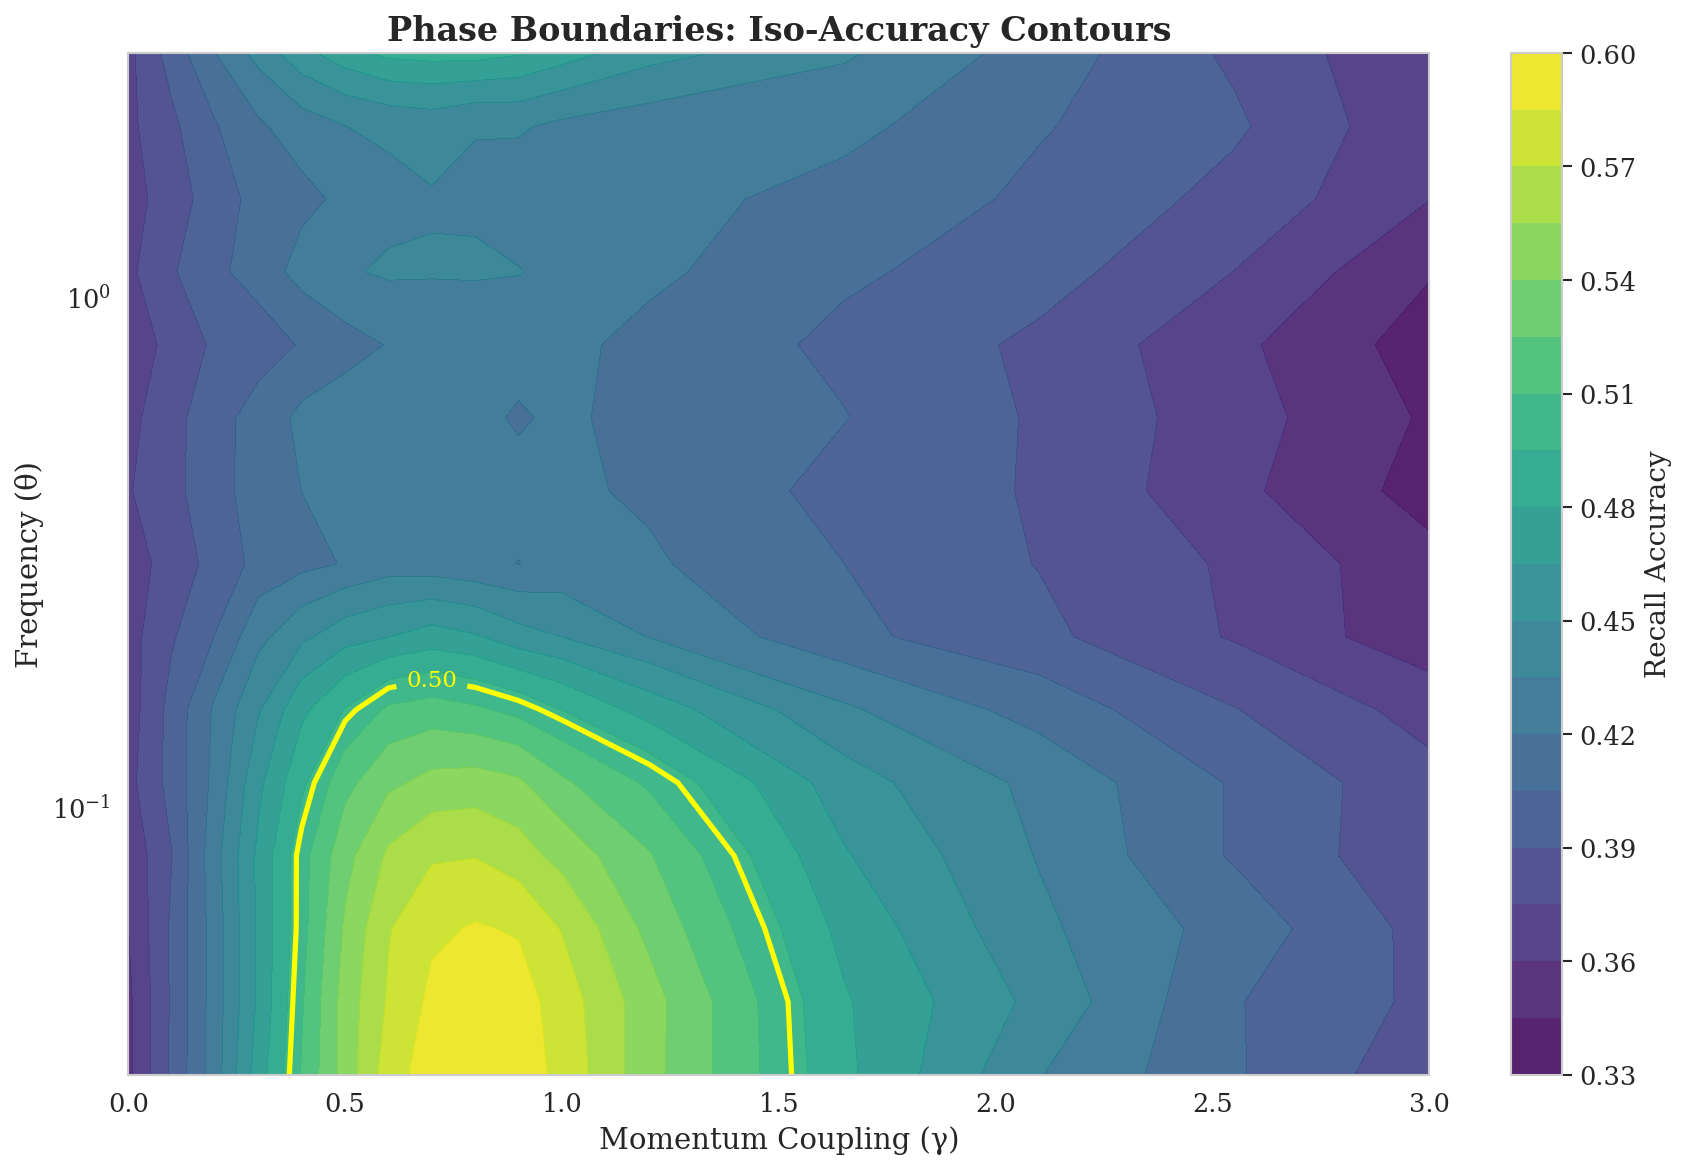

✅ Saved: low_pass_phase_boundaries.png/pdf


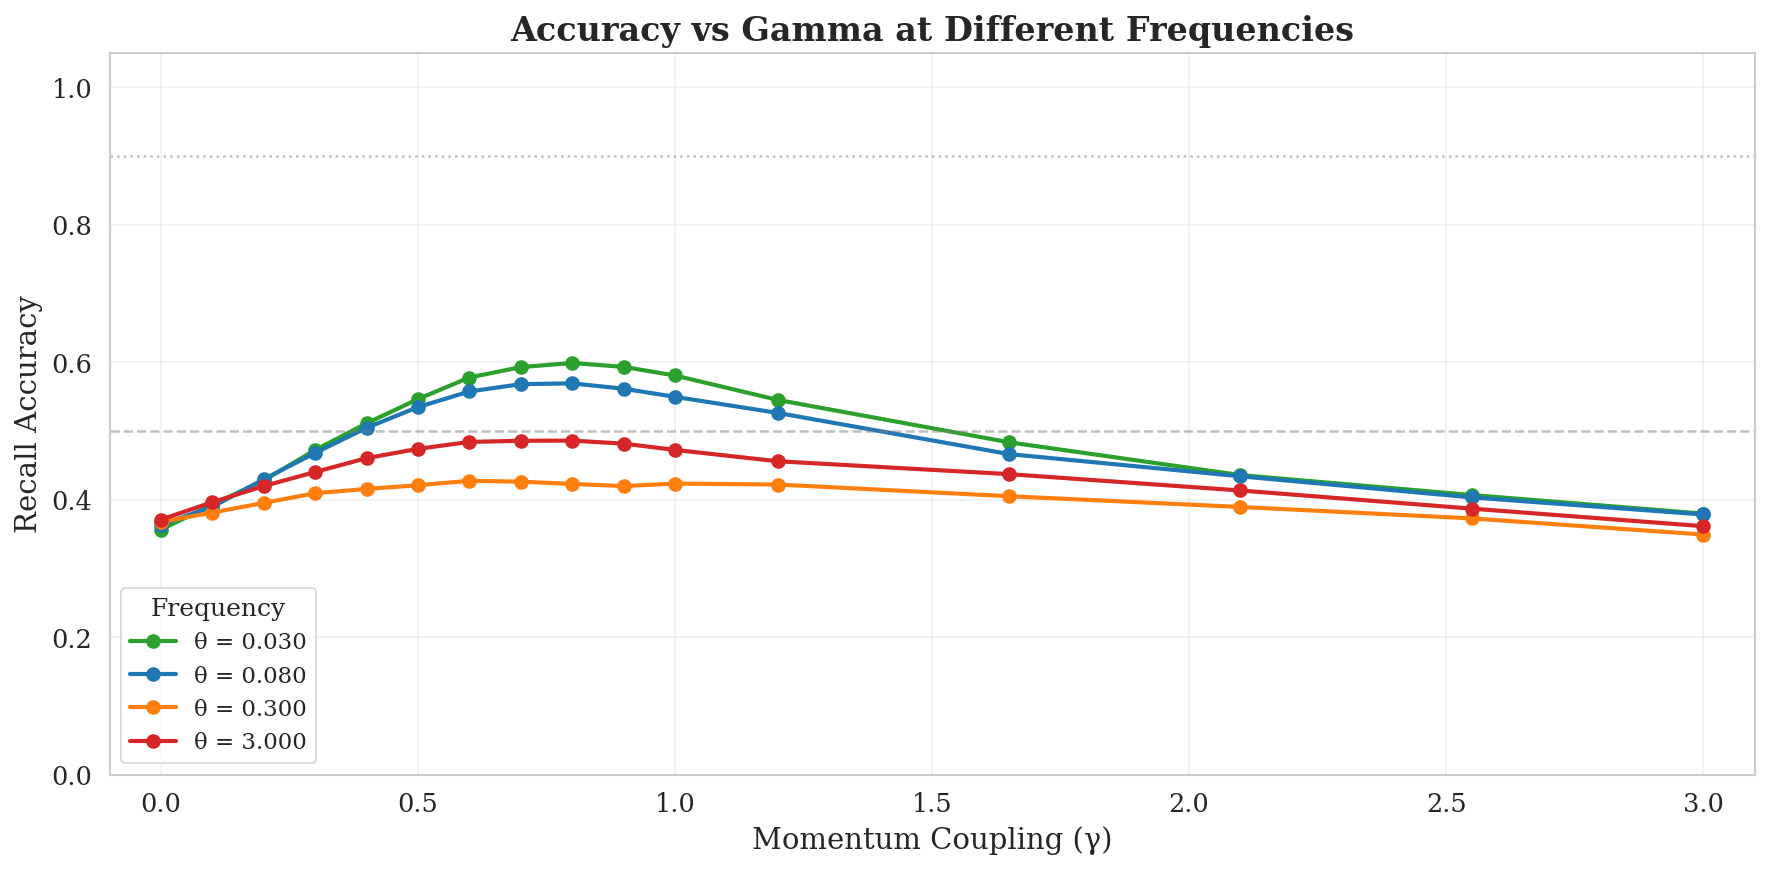

✅ Saved: low_pass_accuracy_slices.png/pdf


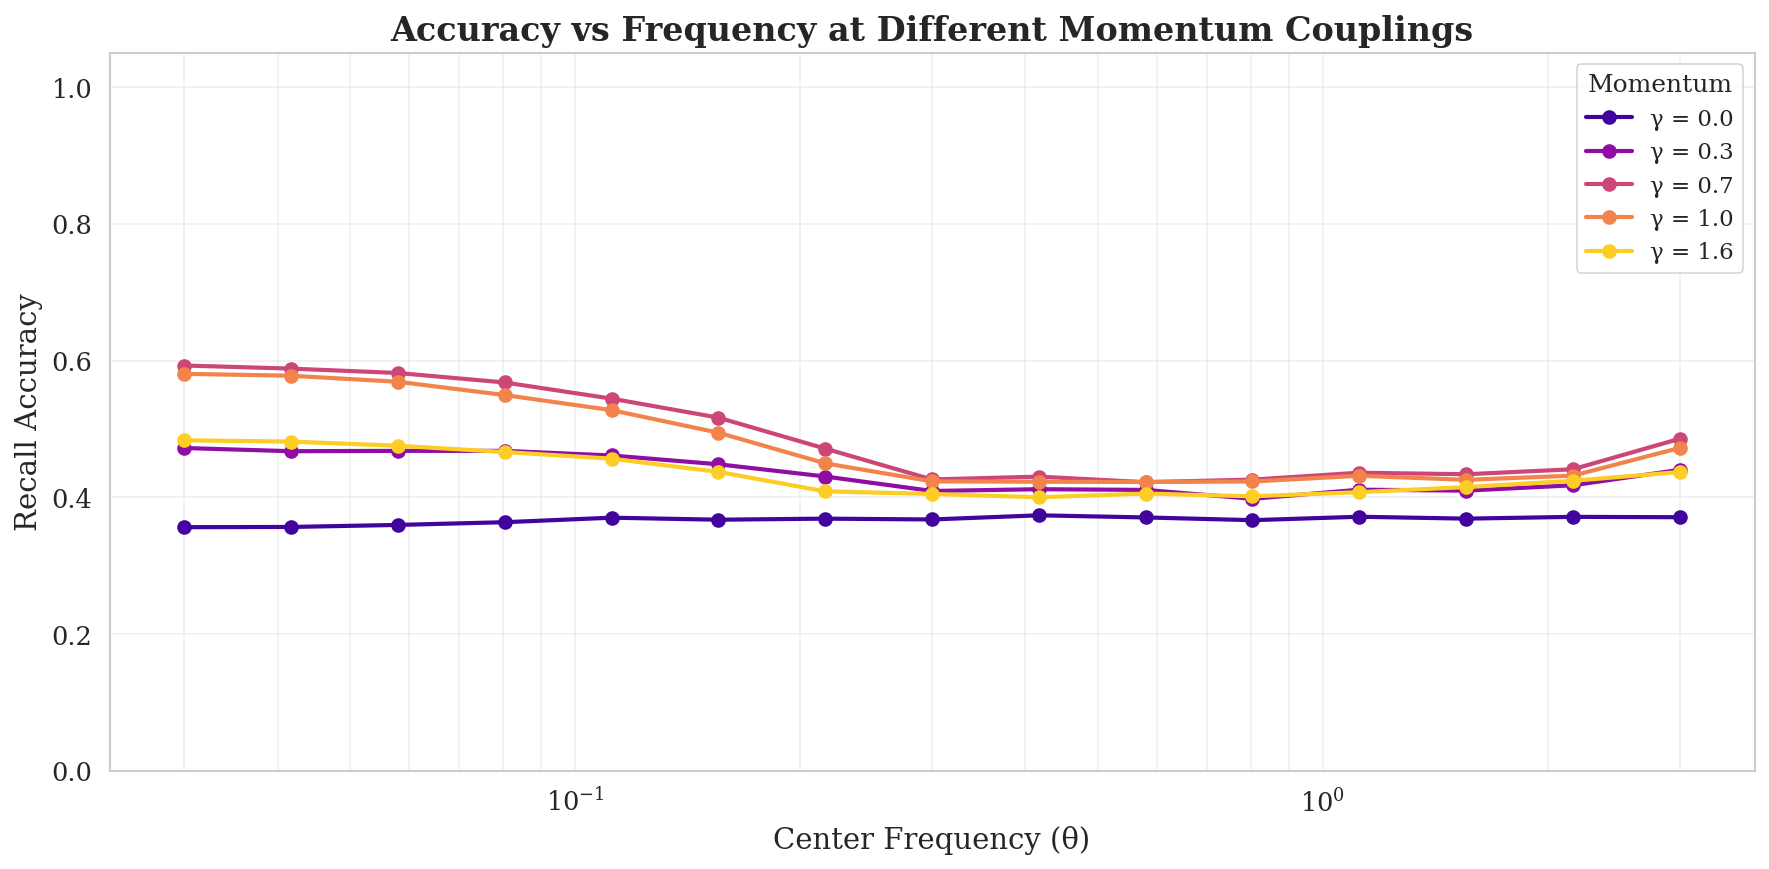

✅ Saved: low_pass_frequency_slices.png/pdf

ALL OUTPUTS GENERATED
Files saved:
  📊 granular_sweep_results.csv
  📈 low_pass_induction_heatmap_with_contours.png/pdf
  📈 low_pass_induction_heatmap_clean.png/pdf
  📈 low_pass_phase_boundaries.png/pdf
  📈 low_pass_accuracy_slices.png/pdf
  📈 low_pass_frequency_slices.png/pdf


In [ ]:
# ============================================================================
# CELL 8: GENERATE PLOTS
# ============================================================================

generate_paper_plots(df_results)

print("\n" + "=" * 66)
print("ALL OUTPUTS GENERATED")
print("=" * 66)
print("Files saved:")
print("  📊 granular_sweep_results.csv")
print("  📈 low_pass_induction_heatmap_with_contours.png/pdf")
print("  📈 low_pass_induction_heatmap_clean.png/pdf")
print("  📈 low_pass_phase_boundaries.png/pdf")
print("  📈 low_pass_accuracy_slices.png/pdf")
print("  📈 low_pass_frequency_slices.png/pdf")

In [ ]:
# ============================================================================
# CELL 9: (OPTIONAL) RELOAD AND REPLOT FROM SAVED CSV
# ============================================================================
# Use this cell if you want to regenerate plots from a previously saved CSV

# Uncomment the lines below to reload and replot:
# df_reloaded = pd.read_csv('granular_sweep_results.csv')
# generate_paper_plots(df_reloaded)